In [1]:
import sqlite3

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***1.***

***Вилучення даних та об'єднання:***

***Мета:*** витягти дані з трьох окремих таблиць та об'єднати їх в один файл формату .csv.

***Кроки:***

* Завантажити дані з трьох таблиць.

* Об'єднати дані в один файл та зберегти його у форматі .csv.

* Прочитати об'єднаний файл за допомогою бібліотеки pandas, щоб створити єдиний DataFrame.

***Перевірка:*** DataFrame повинен містити 74,818 рядків для підтвердження правильності даних.

***Результат:*** єдиний DataFrame слугуватиме основою для подальшого аналізу та візуалізації в наступних завданнях.


In [2]:
connection = sqlite3.connect("/content/drive/MyDrive/db.sqlite3")
cursor = connection.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

for table_name in tables:
    table_name = table_name[0]
    print(f"\nTable: {table_name}")
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = cursor.fetchall()
    for col in columns:
        print(col)



Table: sqlite_sequence
(0, 'name', '', 0, None, 0)
(1, 'seq', '', 0, None, 0)

Table: restaurant_orderitem
(0, 'id', 'INTEGER', 1, None, 1)
(1, 'quantity', 'INTEGER', 1, None, 0)
(2, 'order_id', 'bigint', 1, None, 0)
(3, 'product_id', 'bigint', 1, None, 0)

Table: restaurant_product
(0, 'id', 'INTEGER', 1, None, 1)
(1, 'price', 'decimal', 1, None, 0)
(2, 'name', 'varchar(100)', 1, None, 0)

Table: restaurant_order
(0, 'id', 'INTEGER', 1, None, 1)
(1, 'datetime', 'datetime', 1, None, 0)


In [3]:
pd.read_sql(
"SELECT "
    "restaurant_orderitem.id, restaurant_orderitem.order_id, restaurant_orderitem.product_id, restaurant_product.name, restaurant_orderitem.quantity, restaurant_product.price, restaurant_order.datetime "
    "FROM restaurant_order "
    "INNER JOIN restaurant_orderitem ON restaurant_order.id = restaurant_orderitem.order_id "
    "INNER JOIN restaurant_product ON restaurant_product.id = restaurant_orderitem.product_id",
    connection,
).to_csv(r"data.csv", index=False)
df = pd.read_csv("data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])

In [4]:
df.shape

(74818, 7)

In [5]:
df.head()

,id,order_id,product_id,name,quantity,price,datetime
0,1,1,6,Plain Papadum,2,0.80,2019-08-03 20:25:00
1,2,1,240,King Prawn Balti,1,12.95,2019-08-03 20:25:00
2,3,1,19,Garlic Naan,1,2.95,2019-08-03 20:25:00
3,4,1,36,Mushroom Rice,1,3.95,2019-08-03 20:25:00
4,5,1,111,Paneer Tikka Masala,1,8.95,2019-08-03 20:25:00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          74818 non-null  int64         
 1   order_id    74818 non-null  int64         
 2   product_id  74818 non-null  int64         
 3   name        74818 non-null  object        
 4   quantity    74818 non-null  int64         
 5   price       74818 non-null  float64       
 6   datetime    74818 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 4.0+ MB


In [7]:
df.isnull().sum()

,0
id,0
order_id,0
product_id,0
name,0
quantity,0
price,0
datetime,0


# ***2.***

***Топ-10 найпопулярніших продуктів за кількістю:***

***Мета:*** визначити 10 найпопулярніших продуктів ресторану за кількістю проданих одиниць.

***Кроки:***

* Підрахувати, скільки разів кожен продукт був проданий.

* Визначити 10 найпопулярніших продуктів на основі кількості проданих одиниць.

* Створити кругову діаграму, що відображає відсоткову популярність цих топ-10 продуктів.

***Результат:*** ця діаграма допоможе візуалізувати, які продукти найчастіше купують у ресторані.

In [8]:
top_10_product = df.groupby("name")["quantity"].sum().sort_values(ascending=False)[:10].reset_index()
top_10_product

,name,quantity
0,Plain Papadum,10648
1,Pilau Rice,6367
2,Plain Naan,4983
3,Garlic Naan,3318
4,Plain Rice,2964
5,Onion Bhajee,2749
6,Mango Chutney,2504
7,Chicken Tikka Masala,2473
8,Chapati,1935
9,Mint Sauce,1840


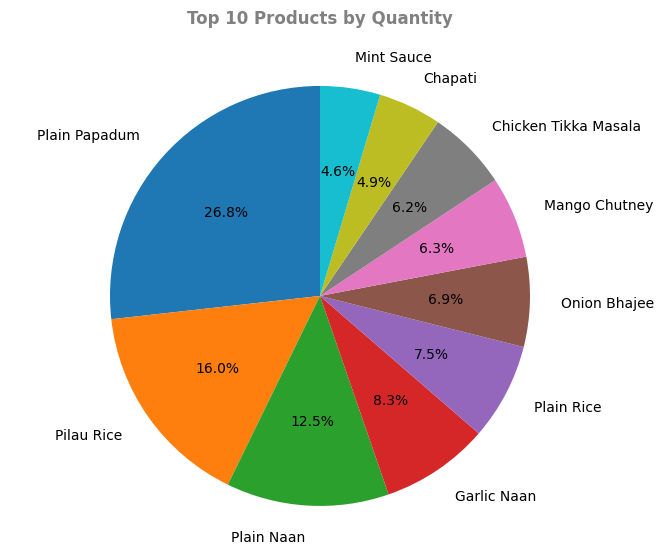

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.pie(top_10_product['quantity'], labels=top_10_product['name'], autopct='%1.1f%%',
       pctdistance=0.6, labeldistance=1.15,startangle=90)

(ax.axis('equal'))
ax.set_title("Top 10 Products by Quantity", fontsize=12, pad=30, color="grey",fontweight='bold', fontstyle='normal')

plt.show()

# ***3.***

***Топ-10 найприбутковіших продуктів за ціною одиниці:***

***Мета:*** розрахувати, які продукти приносять найбільший дохід (топ-10) ресторану.

***Кроки:***

* Розрахувати item_price для кожного продукту в кожному замовленні, множачи price * quantity.

* Підсумувати загальну ціну одиниці для кожного продукту.

* Визначити 10 продуктів, що приносять найбільший дохід.

* Створити кругову діаграму, яка відображає відсотковий вклад цих топ-10 продуктів у дохід.

***Результат:*** ця діаграма покаже, які продукти приносять найбільший дохід для ресторану, що може відрізнятися від продуктів, що продаються найбільше.


In [10]:
df_item_price = df.assign(item_price=df["price"] * df["quantity"])
df_item_price

,id,order_id,product_id,name,quantity,price,datetime,item_price
0,1,1,6,Plain Papadum,2,0.80,2019-08-03 20:25:00,1.60
1,2,1,240,King Prawn Balti,1,12.95,2019-08-03 20:25:00,12.95
2,3,1,19,Garlic Naan,1,2.95,2019-08-03 20:25:00,2.95
3,4,1,36,Mushroom Rice,1,3.95,2019-08-03 20:25:00,3.95
4,5,1,111,Paneer Tikka Masala,1,8.95,2019-08-03 20:25:00,8.95
...,...,...,...,...,...,...,...,...
74813,74814,3255,247,House Red wine 75cl,2,17.95,2016-05-18 18:53:00,35.90
74814,74815,12905,247,House Red wine 75cl,2,17.95,2016-05-14 19:28:00,35.90
74815,74816,3272,247,House Red wine 75cl,2,17.95,2016-05-10 13:18:00,35.90
74816,74817,11404,248,House white wine 75cl,1,17.95,2016-04-07 19:04:00,17.95


In [11]:
top_10_product_by_price = df_item_price.groupby("name")["item_price"].sum().sort_values(ascending=False)[:10].reset_index()
top_10_product_by_price

,name,item_price
0,Chicken Tikka Masala,22133.35
1,Pilau Rice,18782.65
2,Plain Naan,12955.80
3,Korma,12261.50
4,Bombay Aloo,10894.45
5,Onion Bhajee,10858.55
6,Butter Chicken,10626.60
7,Garlic Naan,9788.10
8,Korma - Chicken,9764.45
9,Plain Rice,8743.80


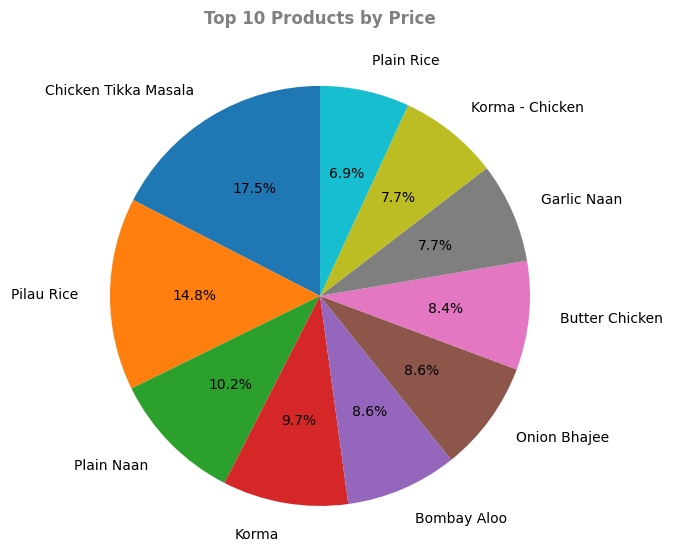

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.pie(top_10_product_by_price['item_price'], labels=top_10_product_by_price['name'], autopct='%1.1f%%',
       pctdistance=0.6, labeldistance=1.15,startangle=90)

(ax.axis('equal'))
ax.set_title("Top 10 Products by Price", fontsize=12, pad=30, color="grey",fontweight='bold', fontstyle='normal')

plt.show()

In [13]:
df.head()

,id,order_id,product_id,name,quantity,price,datetime
0,1,1,6,Plain Papadum,2,0.80,2019-08-03 20:25:00
1,2,1,240,King Prawn Balti,1,12.95,2019-08-03 20:25:00
2,3,1,19,Garlic Naan,1,2.95,2019-08-03 20:25:00
3,4,1,36,Mushroom Rice,1,3.95,2019-08-03 20:25:00
4,5,1,111,Paneer Tikka Masala,1,8.95,2019-08-03 20:25:00


# ***4.***

***Аналіз доходу за годинами:***

***Мета:*** проаналізувати загальний дохід ресторану залежно від часу, коли були зроблені замовлення.

***Кроки:***

* Виділити годину з поля datetime (значення від 0 до 23).

* Підрахувати загальний дохід за кожну годину (сума вартості замовлень).

***Створити стовпчикову діаграму, де:***

* На осі X: Години дня (0-23).

* На осі Y: Загальний дохід за кожну годину.

***Результат:*** це дасть уявлення про те, які години є найбільш прибутковими для ресторану, допомагаючи зрозуміти поведінку клієнтів протягом дня.

In [14]:
df_profit_by_hour = df_item_price.assign(order_hour=df_item_price["datetime"].dt.hour)
df_profit_by_hour

,id,order_id,product_id,name,quantity,price,datetime,item_price,order_hour
0,1,1,6,Plain Papadum,2,0.80,2019-08-03 20:25:00,1.60,20
1,2,1,240,King Prawn Balti,1,12.95,2019-08-03 20:25:00,12.95,20
2,3,1,19,Garlic Naan,1,2.95,2019-08-03 20:25:00,2.95,20
3,4,1,36,Mushroom Rice,1,3.95,2019-08-03 20:25:00,3.95,20
4,5,1,111,Paneer Tikka Masala,1,8.95,2019-08-03 20:25:00,8.95,20
...,...,...,...,...,...,...,...,...,...
74813,74814,3255,247,House Red wine 75cl,2,17.95,2016-05-18 18:53:00,35.90,18
74814,74815,12905,247,House Red wine 75cl,2,17.95,2016-05-14 19:28:00,35.90,19
74815,74816,3272,247,House Red wine 75cl,2,17.95,2016-05-10 13:18:00,35.90,13
74816,74817,11404,248,House white wine 75cl,1,17.95,2016-04-07 19:04:00,17.95,19


In [15]:
item_price_by_order_hour = df_profit_by_hour.groupby("order_hour")["item_price"].sum().reset_index().sort_values(by='order_hour')
item_price_by_order_hour

,order_hour,item_price
0,0,177.95
1,1,54.65
2,2,199.25
3,3,8.90
4,4,63.45
5,5,57.40
6,6,121.60
7,8,447.70
8,9,570.60
9,10,1250.35


/tmp/ipython-input-3968715662.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=item_price_by_order_hour, x="order_hour", y="item_price",  kind="bar",  estimator=np.sum, palette="viridis", height=7)


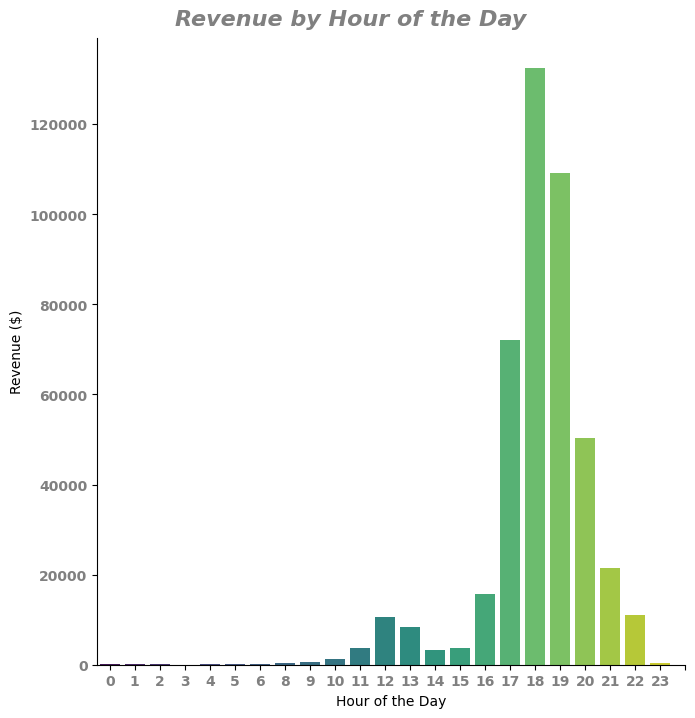

In [16]:
g = sns.catplot(data=item_price_by_order_hour, x="order_hour", y="item_price",  kind="bar",  estimator=np.sum, palette="viridis", height=7)
g.fig.suptitle("Revenue by Hour of the Day", fontsize=16, fontweight='semibold', color='grey', fontstyle= "italic", y=1.02)
g.set_axis_labels("Hour of the Day", "Revenue ($)" )
plt.xticks(range (0, 24), color="grey",fontweight='bold', fontstyle='normal', fontsize=10)
plt.yticks(color="grey",fontweight='bold', fontstyle='normal', fontsize=10)

plt.show()

# ***5.***

***Аналіз доходу за днями тижня:***

***Мета:*** проаналізувати загальний дохід ресторану залежно від дня тижня, коли були зроблені замовлення.

***Кроки:***

* Виділити день тижня з поля datetime (від понеділка до неділі).

* Підрахувати загальний дохід за кожен день тижня.

* Створити стовпчикову діаграму, де:
   * На осі X: Дні тижня (від понеділка до неділі).

  * На осі Y: Загальний дохід за кожен день.

***Результат:*** ця діаграма допоможе визначити, які дні тижня приносять найбільший дохід, що може бути корисним для планування персоналу, акцій чи розкладу.

In [17]:
df_profit_by_weekday = df_profit_by_hour.assign(order_weekday=df_profit_by_hour["datetime"].dt.day_name())
df_profit_by_weekday

,id,order_id,product_id,name,quantity,price,datetime,item_price,order_hour,order_weekday
0,1,1,6,Plain Papadum,2,0.80,2019-08-03 20:25:00,1.60,20,Saturday
1,2,1,240,King Prawn Balti,1,12.95,2019-08-03 20:25:00,12.95,20,Saturday
2,3,1,19,Garlic Naan,1,2.95,2019-08-03 20:25:00,2.95,20,Saturday
3,4,1,36,Mushroom Rice,1,3.95,2019-08-03 20:25:00,3.95,20,Saturday
4,5,1,111,Paneer Tikka Masala,1,8.95,2019-08-03 20:25:00,8.95,20,Saturday
...,...,...,...,...,...,...,...,...,...,...
74813,74814,3255,247,House Red wine 75cl,2,17.95,2016-05-18 18:53:00,35.90,18,Wednesday
74814,74815,12905,247,House Red wine 75cl,2,17.95,2016-05-14 19:28:00,35.90,19,Saturday
74815,74816,3272,247,House Red wine 75cl,2,17.95,2016-05-10 13:18:00,35.90,13,Tuesday
74816,74817,11404,248,House white wine 75cl,1,17.95,2016-04-07 19:04:00,17.95,19,Thursday


In [18]:
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_profit_by_weekday["order_weekday"] = pd.Categorical(df_profit_by_weekday["order_weekday"], categories=weekday_order, ordered=True )

df_profit_by_weekday_sorted = df_profit_by_weekday.sort_values("order_weekday")
df_profit_by_weekday_sorted

,id,order_id,product_id,name,quantity,price,datetime,item_price,order_hour,order_weekday
58974,58975,1554,144,Lamb Tikka Chilli Masala,1,8.95,2018-06-18 21:19:00,8.95,21,Monday
40040,40041,4952,56,Chicken Chaat,1,4.95,2018-11-05 18:37:00,4.95,18,Monday
40039,40040,1108,57,Prawn Puree,1,4.95,2018-11-05 19:27:00,4.95,19,Monday
40038,40039,1108,58,Lamb Tikka,1,4.95,2018-11-05 19:27:00,4.95,19,Monday
40037,40038,6264,59,Vegetable Roll,1,4.95,2018-11-05 20:55:00,4.95,20,Monday
...,...,...,...,...,...,...,...,...,...,...
19868,19869,9040,19,Garlic Naan,1,2.95,2018-10-28 17:53:00,2.95,17,Sunday
19867,19868,6293,18,Plain Rice,1,2.95,2018-10-28 18:04:00,2.95,18,Sunday
19866,19867,9039,19,Garlic Naan,1,2.95,2018-10-28 18:11:00,2.95,18,Sunday
19876,19877,1135,15,Pilau Rice,3,2.95,2018-10-28 15:04:00,8.85,15,Sunday


/tmp/ipython-input-1046467530.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=df_profit_by_weekday_sorted, x="order_weekday", y="item_price",  kind="bar",  estimator=np.sum, palette="viridis", height=7, errorbar=None)


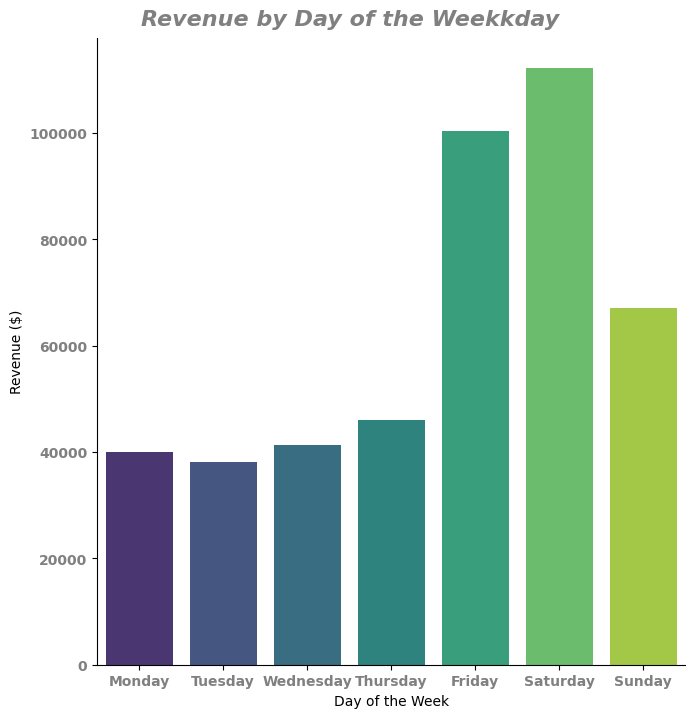

In [21]:
g = sns.catplot(data=df_profit_by_weekday_sorted, x="order_weekday", y="item_price",  kind="bar",  estimator=np.sum, palette="viridis", height=7, errorbar=None)
g.fig.suptitle("Revenue by Day of the Weekkday", fontsize=16, fontweight='semibold', color='grey', fontstyle= "italic", y=1.02)
g.set_axis_labels( "Day of the Week", "Revenue ($)" )
plt.xticks(color="grey",fontweight='bold', fontstyle='normal', fontsize=10)
plt.yticks(color="grey",fontweight='bold', fontstyle='normal', fontsize=10)

plt.show()